In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import networkx as nx

from collections import Counter

N = 35

G = 2

In [2]:
lambda_a = G + (N % 3)
lambda_b = G + (N % 5)
N_a = 2 + (G % 2)
N_b = 1 + (N % 2)
R_a = 1 + (G % 2)
R_b = 2 - (G % 2)

lambda_S = (N_a + N_b - (G % 2)) * (G + (N % 4))

print('Лямбда А =',lambda_a)
print('Лямбда Б =',lambda_b)
print('Na =',N_a)
print('Nb =',N_b)
print('Ra =',R_a)
print('Rb =',R_b)
print('Лямбда S =',lambda_S)

Лямбда А = 4
Лямбда Б = 2
Na = 2
Nb = 2
Ra = 1
Rb = 2
Лямбда S = 20


Система состоит из двух последовательно соединенных частей - A и B. Рассмотрим и пронумеруем возможные состояния частей.

In [3]:
states = []
for a in range(N_a + R_a + 1):  # 0 до 3
    for b in range(1,N_b + R_b + 1):  # 1 до 4, случай с 0 не рассматриваем т.к. при b=1 система перестает работать
        states.append((a, b))

print("Possible States:")
for i, state in enumerate(states):
    print(f"State {i}: {state}")

Possible States:
State 0: (0, 1)
State 1: (0, 2)
State 2: (0, 3)
State 3: (0, 4)
State 4: (1, 1)
State 5: (1, 2)
State 6: (1, 3)
State 7: (1, 4)
State 8: (2, 1)
State 9: (2, 2)
State 10: (2, 3)
State 11: (2, 4)
State 12: (3, 1)
State 13: (3, 2)
State 14: (3, 3)
State 15: (3, 4)


In [4]:
def state_to_number(a, b):
    """
    Преобразует параметры (a, b) в номер состояния.
    
    :param a: Первая координата состояния.
    :param b: Вторая координата состояния.
    :return: Номер состояния от 0 до 15.
    """
    if not (0 <= a <= 3) or not (1 <= b <= 4):
        raise ValueError("Параметры 'a' должны быть в пределах [0, 3], а 'b' — в [1, 4].")
    
    return a * 4 + (b - 1)

def number_to_state(state_number):
    """
    Преобразует номер состояния в параметры (a, b).
    
    :param state_number: Номер состояния от 0 до 15.
    :return: Кортеж (a, b).
    """
    if not (0 <= state_number <= 15):
        raise ValueError("Номер состояния должен быть в диапазоне от 0 до 15.")
    
    a = state_number // 4
    b = (state_number % 4) + 1
    return a, b

Матрица интенсивностей переходов. Имеет размерность 16 на 16. Индекс текущего состояния =  a * B_states + b; Проходим по каждому состоянию и указываем для него вероятности перехода в соседние состояния при отказе Б как интенсивность Б, и при отказе А как интенсивность А


In [5]:
def create_intensity_matrix(lambda_a, lambda_b):
    """
    Создает матрицу интенсивностей переходов для 16 состояний.

    :param lambda_a: Интенсивность перехода для уменьшения a на 1.
    :param lambda_b: Интенсивность перехода для уменьшения b на 1.
    :return: Матрица интенсивностей переходов размером 16x16.
    """
    size = 16
    Q = np.zeros((size, size))  # Инициализация матрицы нулями


    for a in range(4):  # a может быть 0, 1, 2 или 3
        for b in range(1, 5):  # b может быть 1, 2, 3 или 4

            system_work = a > 0 and b > 1
            current_state = state_to_number(a, b)
            transition_sum = 0

            # Проверка на возможность уменьшения устройств
            if a > 0 and system_work:  # Переход из (a, b) в (a-1, b)
                next_state_a = state_to_number(a - 1, b)
                Q[current_state, next_state_a] = lambda_a
                transition_sum += lambda_a
            
            if b > 1 and system_work:  # Переход из (a, b) в (a, b-1)
                next_state_b = state_to_number(a, b - 1)
                Q[current_state, next_state_b] = lambda_b
                transition_sum += lambda_b

            # Ремонт устройств
            broken_A = 3 - a  # Количество сломанных устройств типа A
            broken_B = 4 - b  # Количество сломанных устройств типа B

            need_repair = (broken_A + broken_B) > 0 

            if need_repair and broken_A < broken_B:
                repaired_state = state_to_number(a, b + 1)
                Q[current_state,repaired_state] = lambda_S
                transition_sum += lambda_S
            elif need_repair:
                repaired_state = state_to_number(a+1, b)
                Q[current_state,repaired_state] = lambda_S
                transition_sum += lambda_S

            # Установка диагонального элемента
            Q[current_state, current_state] = -transition_sum

    return Q

# Генерация матрицы Q
Q = create_intensity_matrix(lambda_a, lambda_b)

# Форматированный вывод матрицы
width = 5
for row in Q:
    print(" | ".join(f"{value:>{width}.2f}" for value in row))

-20.00 |  0.00 |  0.00 |  0.00 | 20.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 | -20.00 |  0.00 |  0.00 |  0.00 | 20.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 | -20.00 |  0.00 |  0.00 |  0.00 | 20.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  0.00 | -20.00 |  0.00 |  0.00 |  0.00 | 20.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  0.00 |  0.00 | -20.00 | 20.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  4.00 |  0.00 |  0.00 |  2.00 | -26.00 |  0.00 |  0.00 |  0.00 | 20.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  4.00 |  0.00 |  0.00 |  2.00 | -26.00 |  0.00 |  0.00 |  0.00 | 20.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00
 0.00 |  0.00 |  0.00 |  4.00 |  0.00 |  0.00 |  2.00 | -26.00 |  0.00 |  0.00 |  0.00 | 20.00 |  0.00 |  0.00 

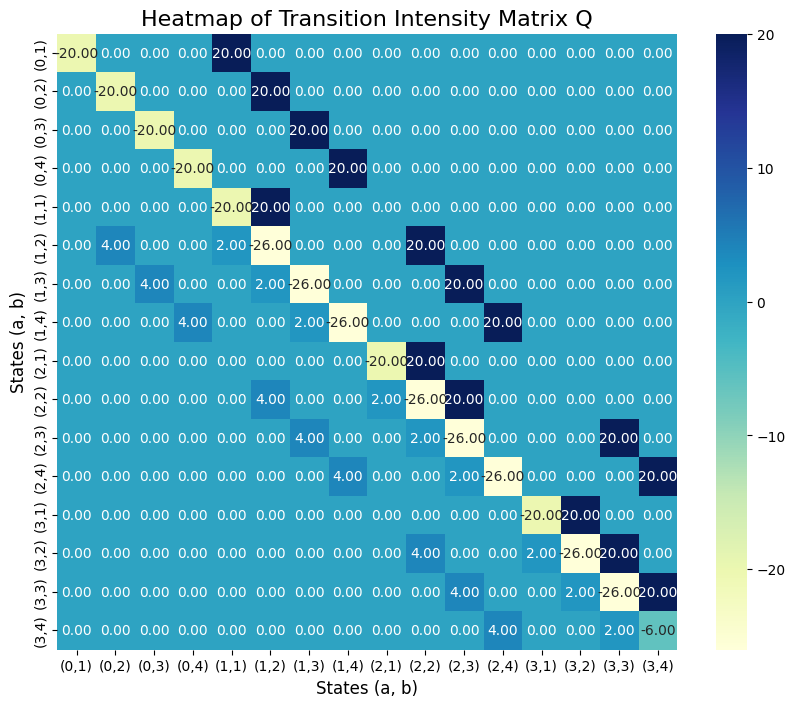

In [6]:
# Создание меток для осей
states = [f'({a},{b})' for a in range(4) for b in range(1, 5)]

# Настройка heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(Q, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=states, yticklabels=states)
plt.title('Heatmap of Transition Intensity Matrix Q', fontsize=16)
plt.xlabel('States (a, b)', fontsize=12)
plt.ylabel('States (a, b)', fontsize=12)
plt.show()

3аписать алгебраические уравнения Колмогорова для установившегося режима работы;
Рассчитать предельные вероятности состояний системы;

In [7]:
# Стандартная форма для решения системы Колмогорова: Q^T * π = 0
# Извлечение вектора pi  из системы Q^T * π = 0, добавление условия нормировки
A = Q.T.copy()
b = np.zeros(A.shape[0])

# Добавим условие нормировки
A[-1] = np.ones(Q.shape[0])
b[-1]= 1

# Решаем систему
pi = np.linalg.solve(A, b)

# Печать результата
print("Стационарные вероятности:")
for i, prob in enumerate(pi):
    a = i // 4
    b = (i % 4) + 1
    print(f"P({a}, {b}) = {prob:.7f}")

Стационарные вероятности:
P(0, 1) = -0.0000000
P(0, 2) = 0.0003849
P(0, 3) = 0.0016256
P(0, 4) = 0.0045685
P(1, 1) = 0.0001925
P(1, 2) = 0.0019247
P(1, 3) = 0.0081282
P(1, 4) = 0.0228426
P(2, 1) = 0.0005559
P(2, 2) = 0.0055593
P(2, 3) = 0.0332836
P(2, 4) = 0.1256345
P(3, 1) = 0.0007091
P(3, 2) = 0.0070907
P(3, 3) = 0.0850888
P(3, 4) = 0.7024110


5.	рассчитать математические ожидания прикладных характеристик системы: 
●	вероятности отказа системы;
●	числа готовых к эксплуатации устройств каждого типа;
●	коэффициента загрузки ремонтной службы.

In [8]:
# 1. Вероятность отказа системы
P_failure = np.sum(pi[0:4]) + np.sum(pi[state_to_number(a, 1)] for a in range(4))

# 2. Число готовых к эксплуатации устройств каждого типа
E_NA = np.sum([a * np.sum(pi[state_to_number(a, b)] for b in range(1, 5)) for a in range(1, 4)])  # a от 1 до 3
E_NB = np.sum([b * pi[state_to_number(a, b)] for a in range(4) for b in range(1, 5)])  # b от 1 до 4

# 3. Коэффициент загрузки ремонтной службы
E_R = np.sum([lambda_S * pi[state_to_number(a, b)] for a in range(4) for b in range(1, 5) if (a == 0 or b == 1)])

# Вывод результатов
print(f"Вероятность отказа системы: {P_failure:.4f}")
print(f"Ожидаемое число готовых устройств типа A: {E_NA:.4f}")
print(f"Ожидаемое число готовых устройств типа B: {E_NB:.4f}")
print(f"Коэффициент загрузки ремонтной службы: {E_R:.4f}")

Вероятность отказа системы: 0.0080
Ожидаемое число готовых устройств типа A: 2.7491
Ожидаемое число готовых устройств типа B: 3.8376
Коэффициент загрузки ремонтной службы: 0.1607


C:\Users\admin\AppData\Local\Temp\ipykernel_1244\1516648127.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  P_failure = np.sum(pi[0:4]) + np.sum(pi[state_to_number(a, 1)] for a in range(4))
C:\Users\admin\AppData\Local\Temp\ipykernel_1244\1516648127.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  E_NA = np.sum([a * np.sum(pi[state_to_number(a, b)] for b in range(1, 5)) for a in range(1, 4)])  # a от 1 до 3


In [9]:
def kolmogorov_equations(t, p, Q):
    # Создаем массив для производных
    dpdt = np.zeros_like(p)
    
    # Заполняем производные по уравнениям Колмогорова
    for i in range(len(p)):
        dpdt[i] = np.sum(Q[:, i] * p)  # Суммируем по всем состояниям

    return dpdt

def get_solution(time):
    # Начальные вероятности
    initial_state = np.zeros(16) # Вектор начального состояния, инициализируем нулями
    initial_state[15] = 1 #Начальное состояние (3,4)

    # Время интеграции
    t_span = (0, time)  #От 0 до time
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # 100 точек во времени

    # Решение системы уравнений
    solution = solve_ivp(kolmogorov_equations, t_span, initial_state, args=(Q,), t_eval=t_eval)
    # Выводим результаты
    return solution


solution = get_solution(2)


def find_transition_time(solution, pi):
    threshold = 0.01 * np.linalg.norm(pi)  # 10% от нормы предельного вектора
    for i, p in enumerate(solution.y.T):
        residual = np.linalg.norm(p - pi)  # Норма невязки
        if residual <= threshold:
            return solution.t[i]  # Вернуть время
    return None, None  # Если не найдено


transition_time = find_transition_time(solution, pi) * 2

transion_solution = get_solution(transition_time)
print ('Удвоенное время переходного процесса', transition_time)

Удвоенное время переходного процесса 0.686868686868687


Строим график вероятностей

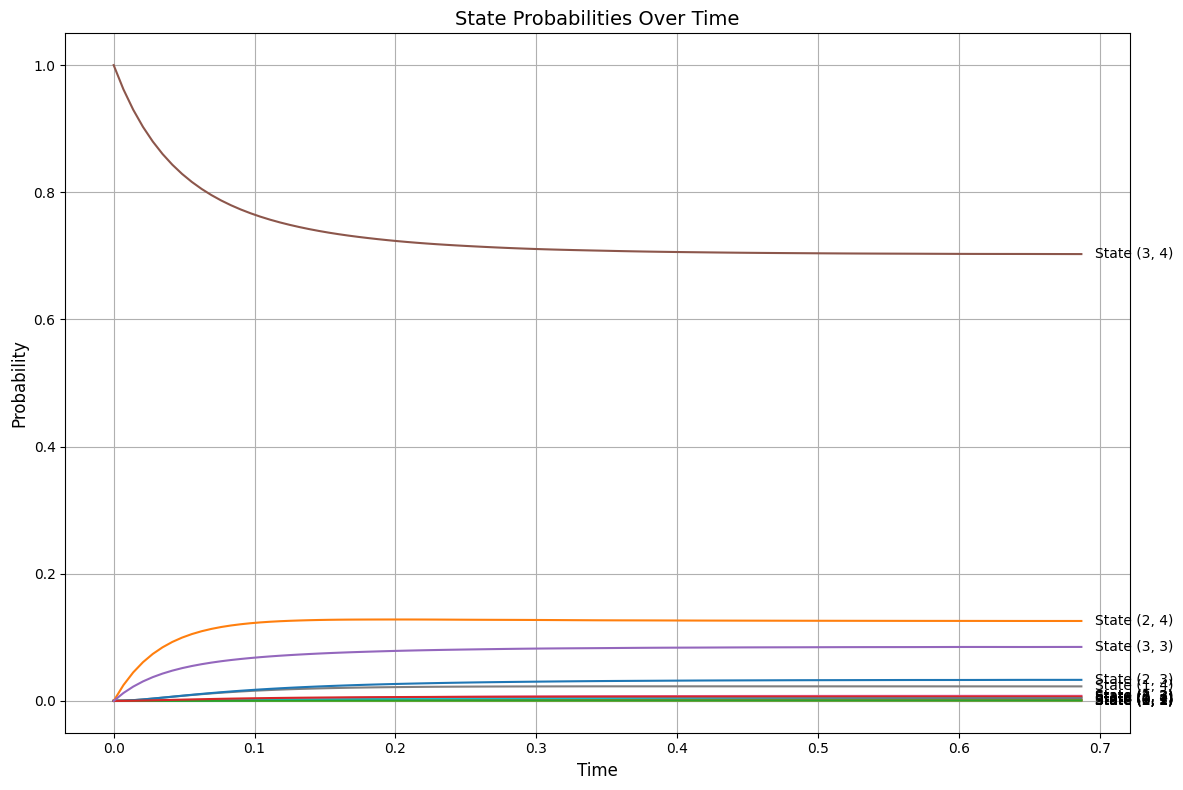

In [10]:
# Установка размера графика
plt.figure(figsize=(12, 8))  # Увеличиваем размер графика



# Построение графиков вероятности
for i in range(16):
    plt.plot(transion_solution.t, transion_solution.y[i], label=f'State {number_to_state(i)}')  # Используем формат (a, b)
    
    # Добавление метки рядом с линией
    final_time = transion_solution.t[-1]  # Берем последнее время для аннотации
    final_prob = transion_solution.y[i][-1]  # Вероятность в конце
    
    # Перемещение аннотаций вправо
    plt.annotate(
        f'State {number_to_state(i)}', 
        xy=(final_time, final_prob), 
        xytext=(10, 0),  # Смещение метки вправо
        textcoords='offset points',
        fontsize=10,  # Размер шрифта
        verticalalignment='center',  # Выравнивание по центру по вертикали
        ha='left'  # Выравнивание текста по левой стороне
    )

# Заголовок и подписываем оси
plt.title('State Probabilities Over Time', fontsize=14)  # Заголовок графика
plt.xlabel('Time', fontsize=12)  # Подпись оси X
plt.ylabel('Probability', fontsize=12)  # Подпись оси Y

# Настроим отображение для лучшего визуального эффекта
plt.tight_layout()  # Автоматическая подстройка размеров для лучшего отображения
plt.grid(True)  # Добавляем сетку для лучшей читаемости графика
plt.show()  # Отображаем график


Иммитационное моделирование

In [11]:
def simulate():
    cur_state = 15
    a,b = number_to_state (cur_state)
    print (a,b,0)
    cur_time = 0

    while a > 0 and b >= 1:
        # Проверяем, что интенсивность выхода из текущего состояния отрицательная
        if Q[cur_state, cur_state] >= 0:
            break  # Если интенсивность не подходит, выходим из цикла

        # Вычисляем время простоя до следующего события
        idle_time = np.random.exponential(- 1/Q[cur_state, cur_state])
        cur_time += idle_time

        if cur_time > transition_time:
            print(f"Превышено время моделирования: {cur_time:.2f}")
            break
        
        # Выбор следующего состояния
        # Создаем список возможных переходов и их вероятностей
        transition_probs = Q[cur_state] / -Q[cur_state, cur_state]  # Вероятности переходов
        transition_probs = np.clip(transition_probs, 0, None)  # Убираем отрицательные значения
        transition_probs /= transition_probs.sum()  # Нормализуем
        
        # Выбор следующего состояния с помощью распределения вероятностей
        next_state = np.random.choice(np.arange(Q.shape[0]), p=transition_probs)
        
        # Обновление текущего состояния
        cur_state = next_state
        a, b = number_to_state(cur_state)  # Переопределяем a и b для нового состояния
        print (a,b, round(cur_time,4))

    return cur_time


results = simulate()

# Статистический анализ
mean_time = np.mean(results)

# Вывод времени безотказной работы системы
print(f"Среднее время безотказной работы: {mean_time:.2f}")

3 4 0
3 3 0.1636
3 4 0.2303
2 4 0.2901
3 4 0.3055
2 4 0.31
3 4 0.3399
2 4 0.3772
3 4 0.4301
3 3 0.4975
3 4 0.5042
3 3 0.6101
Превышено время моделирования: 0.77
Среднее время безотказной работы: 0.77


Функции для моделирования в терминах дискретно-событийного моделирования

In [12]:

def check_repair_to_add():
      global need_repair_a, need_repair_b, is_repairing, total_time, events
      if need_repair_a + need_repair_b <= 0 or is_repairing:
        return
      elif need_repair_a < need_repair_b:
        repair_time = np.random.exponential(1 / lambda_S)
        new_repair_event_time = total_time + repair_time
        events.append((new_repair_event_time, 'repair_B'))
        is_repairing = True  
      else:
        repair_time = np.random.exponential(1 / lambda_S)
        new_repair_event_time = total_time + repair_time
        events.append((new_repair_event_time, 'repair_A'))
        is_repairing = True
      events.sort()

           

def add_a_detail():
        global total_time, events
        new_fail_time_A = total_time + np.random.exponential(1 / lambda_a)
        events.append((new_fail_time_A, 'A'))  # Добавляем новое время отказа для резервного A
        events.sort()

def add_b_detail():
        global total_time, events
        new_fail_time_B = total_time + np.random.exponential(1 / lambda_b)
        events.append((new_fail_time_B, 'B'))  # Добавляем новое время отказа для резервного A
        events.sort()


def repair_a():
    global is_repairing, need_repair_a, reserve_A, working_A
    is_repairing = False
    need_repair_a -= 1
    if working_A < 2: 
         working_A += 1
         add_a_detail()
    else: reserve_A += 1

def repair_b():
    global is_repairing, need_repair_b, reserve_B, working_B
    is_repairing = False
    need_repair_b -= 1
    if working_B < 2: 
         working_B += 1
         add_b_detail()
    else: reserve_B+= 1

def broke_a():
     global need_repair_a, reserve_A, working_A
     need_repair_a += 1
     if reserve_A > 0:
              reserve_A -= 1  # Используем одно резервное A
              add_a_detail()
     else:
              working_A -= 1

def broke_b():
     global need_repair_b, reserve_B, working_B
     need_repair_b += 1
     if reserve_B > 0:
              reserve_B -= 1  # Используем одно резервное A
              add_b_detail()
     else:
              working_B -= 1

Дискретно-событийное моделирование

In [13]:

# Глобальные переменные
working_A = 0
working_B = 0
total_time = 0
events = []
reserve_A = 0
reserve_B = 0
need_repair_a = 0
need_repair_b = 0
is_repairing = False

def simulate3():
    global working_A, working_B, total_time, reserve_A, reserve_B, need_repair_a, need_repair_b, is_repairing, events
    working_A = N_a  # Работающие устройства A
    working_B = N_b  # Работающие устройства B
    total_time = 0   # Общее время безотказной работы системы

    # Времена отказов для работающих устройств
    fail_times_A = [np.random.exponential(1 / lambda_a) for _ in range(N_a)]
    fail_times_B = [np.random.exponential(1 / lambda_b) for _ in range(N_b)]

    # События времени отказа для A и B
    events = [(fail_time, 'A') for fail_time in fail_times_A] + \
             [(fail_time, 'B') for fail_time in fail_times_B]

    # Сортируем события по времени
    events.sort()

    # Счетчик резервных устройств
    reserve_A = R_a  # Число запасных устройств A
    reserve_B = R_b  # Число запасных устройств B

    # Счетчик сломанных устройств

    need_repair_a = 0
    need_repair_b = 0

    # Флаг, указывающий, что идет процесс ремонта
    is_repairing = False

    #print(working_A, working_B, reserve_A, reserve_B)
    #print(events)

    print(f"{'Working A':<10} {'Working B':<10} {'Reserve A':<10} {'Reserve B':<10} {'Need Repair A':<15} {'Need Repair B':<15} {'Events':<40}")
    print("=" * 100)
    # Печатаем текущее состояние системы
    print(f"{working_A:<10} {working_B:<10} {reserve_A:<10} {reserve_B:<10} {need_repair_a:<15} {need_repair_b:<15} {str(events):<40}")

    while events:
        # Получаем следующее событие
        next_event_time, device_type = events.pop(0)

        # Проверяем, превышает ли общее время моделирования transition_time
        if total_time + next_event_time > transition_time:
            print(f"Превышено время моделирования: {total_time + next_event_time:.2f}")
            break

        # Увеличиваем общее время работы системы
        total_time += next_event_time

        if device_type == 'A': broke_a()
        elif device_type == 'B': broke_b()
        elif device_type == 'repair_A': repair_a()
        elif device_type == 'repair_B': repair_b()

        check_repair_to_add()

        # Печатаем текущее состояние системы
        print(f"{working_A:<10} {working_B:<10} {reserve_A:<10} {reserve_B:<10} {need_repair_a:<15} {need_repair_b:<15} {str(events):<40}")

        if working_B < N_b or working_A < 1:
            print ('Система вышла из строя')


    return total_time
 
# Проведение симуляции
results = simulate3()



Working A  Working B  Reserve A  Reserve B  Need Repair A   Need Repair B   Events                                  
2          2          1          2          0               0               [(0.018472723968302438, 'A'), (0.2678965872439454, 'B'), (0.30358117282451086, 'A'), (0.6723198564907629, 'B')]
2          2          0          2          1               0               [(0.0663387213432371, 'repair_A'), (0.2678965872439454, 'B'), (0.30358117282451086, 'A'), (0.37945618686201005, 'A'), (0.6723198564907629, 'B')]
2          2          1          2          0               0               [(0.2678965872439454, 'B'), (0.30358117282451086, 'A'), (0.37945618686201005, 'A'), (0.6723198564907629, 'B')]
2          2          1          1          0               1               [(0.30358117282451086, 'A'), (0.3698863759348516, 'repair_B'), (0.37945618686201005, 'A'), (0.4575690253947463, 'B'), (0.6723198564907629, 'B')]
2          2          0          1          1               1     